## Модуль класифікації типів земної поверхні на основі аналізу аеро-космічних знімків

## Configuration:

In [1]:
from sentinelhub import SHConfig

config = SHConfig()

config

SHConfig(
  instance_id='********************************5aca',
  sh_client_id='********************************1614',
  sh_client_secret='************************************{G8,',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='****************IBPG',
  aws_secret_access_key='************************************l3SB',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

In [2]:
SHConfig.get_config_location()

'C:\\Users\\andre\\.config\\sentinelhub\\config.toml'

### Частина 1:
   1. Визначте сферу інтересів (AOI):
        - Отримайте схему Словенії (подається)
        - Розділіть на керовані менші плитки
        - Виберіть невелику область 5x5 для класифікації
   2. Використовуйте інтегрований пакунок sentinelhub-py, щоб заповнити EOPatches деяким вмістом (дані смуг, хмарні маски, ...)
        - Визначте часовий інтервал (у цьому прикладі використовується весь 2019 рік)
   3. Додайте додаткову інформацію з комбінацій смуг (норм. індекс рослинності - NDVI, норм. індекс води - NDWI)
   4. Додайте довідкову карту (надається)
        - Перетворіть надані векторні дані на растрові та додайте їх до EOPatches

### Частина 2:
   5. Підготуйте навчальні дані
        - Видаліть надто мутні сцени
        - Виконайте часову інтерполяцію (заповнення пропусків і повторна вибірка до тих самих дат)
        - Нанести ерозію
        - Випадкова просторова вибірка EOPatches
        - Розділені патчі для навчання/перевірки
   6. Побудуйте та навчіть модель ML
        - Зробіть прогноз для кожного патча
   7. Перевірте модель
   8. Візуалізуйте результати

Давайте розпочнемо!

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import LinearInterpolationTask, NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

# Частина 1
1. Визначте сферу інтересів (AOI):
- Географічну форму Словенії було взято з бази даних Natural Earth і застосовано буфер 500 м. Форма доступна в репозиторії: example_data/svn_border.geojson
- Перетворіть його на вибрану CRS: прийнято як CRS центральної плитки UTM (UTM_33N)
- Розділіть його на менші, керовані прямокутні плитки, які не перекриваються
- Виконайте класифікацію на вибраній області 5x5

Переконайтеся, що ваш вибір CRS збігається з CRS ваших довідкових даних.

Якщо у вас виникли проблеми із завантаженням порожніх даних, спробуйте змінити CRS на те, що краще підходить для розташування AOI.

Отримати кордон країни

# !!Змінити svn_border.geojson в exemple_data

Dimension of the area is 41676 x 43520 m2


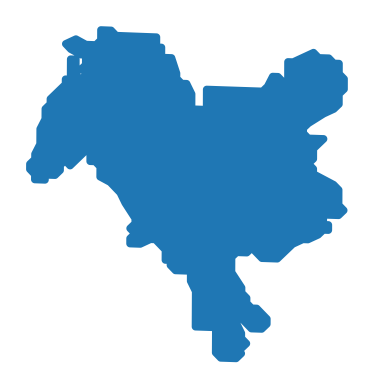

In [2]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(".", "example_data")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
RESULTS_FOLDER = os.path.join(".", "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "kyiv.geojson"))
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[0]
#print(country_shape)

# Plot country
country.plot()
plt.axis("off")

# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

In [3]:
# Створення роздільника, щоб отримати список bboxів зі стороною 5 км
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 1000)
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]
bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 331

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = "grid_slovenia_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

#print(bbox_list)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Візуалізуйте виділення

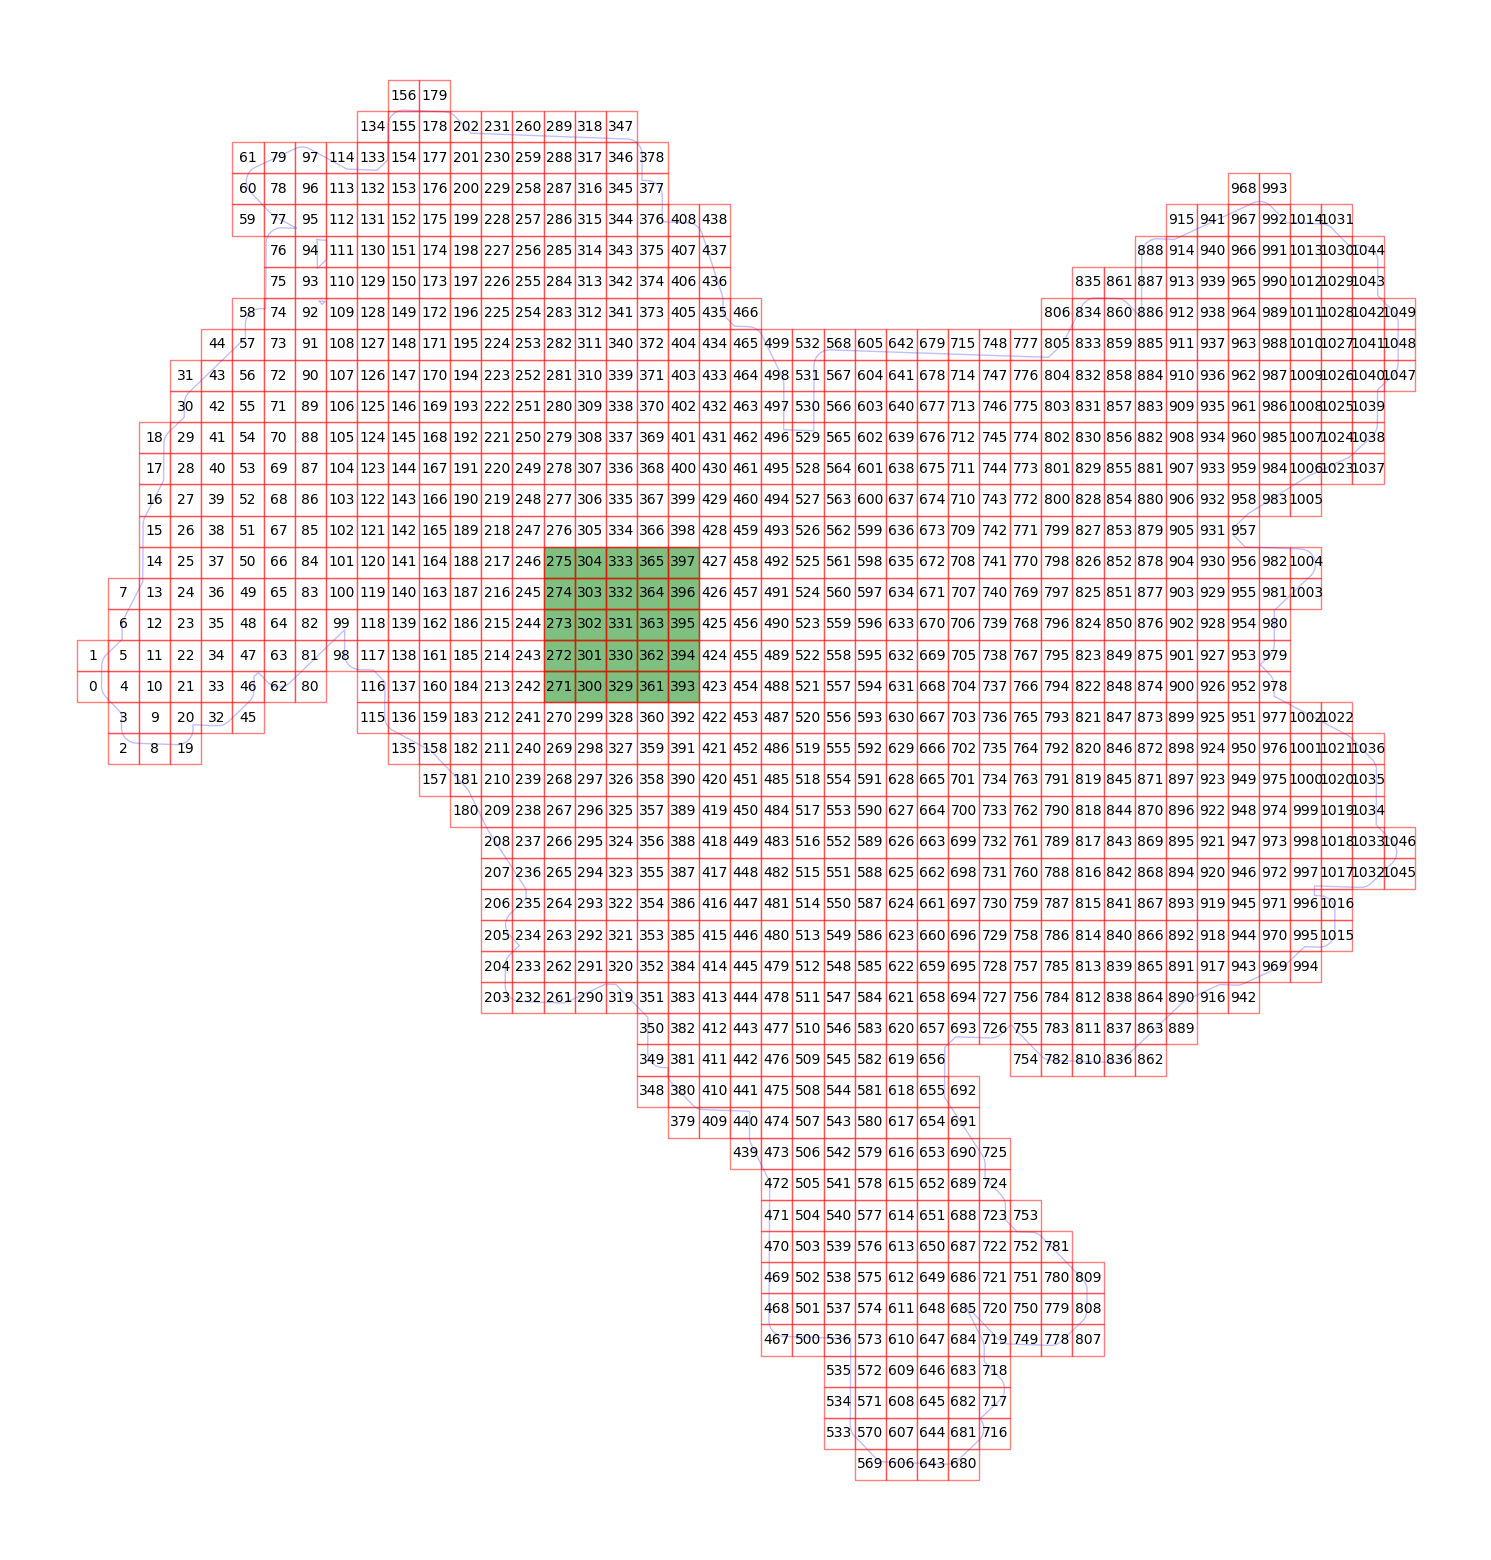

In [5]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_title("Selected 5x5 tiles from Ukraine", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patchIDs)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

## 2. - 4. Заповніть EOPatches даними:
Тепер настав час створити EOPatches і заповнити їх даними Sentinel-2 за допомогою сервісів Sentinel Hub. Ми додамо такі дані до кожного EOPatch:

- Спеціальний список діапазонів L1C [B02, B03, B04, B08, B11, B12], який відповідає довжинам хвиль [B, G, R, NIR, SWIR1, SWIR2].

- Хмарна маска SentinelHub

Додатково додамо:

- Розрахована інформація про NDVI, NDWI та NDBI

- Маска дійсності на основі отриманих даних із Sentinel і хмарного покриття. Дійсний піксель, якщо:

    1. IS_DATA == Правда
    2. CLOUD_MASK == 0 (1 означає хмарні пікселі, а 255 означає NO_DATA)

EOPatch створюється та обробляється за допомогою EOTasks, які об’єднані в EOWorkflow. У цьому прикладі остаточний робочий процес виконується для всіх патчів, збережених у вказаному каталозі.

## Визначте кілька необхідних настроюваних завдань EOT

In [469]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

## Визначте завдання робочого процесу

In [470]:
# BAND DATA
# Add a request for S2  bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Допоможіть! Я вважаю за краще розраховувати маски хмар самостійно!
Якщо ви хочете розрахувати s2cloudless маски та ймовірності (майже) з нуля, ви можете зробити це, використовуючи наступні два EOTasks замість першого вище.

```python
band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')],
)

add_clm = CloudMaskTask(data_feature='BANDS',
                        all_bands=True,
                        processing_resolution=160,
                        mono_features=('CLP', 'CLM'),
                        mask_feature=None,
                        average_over=16,
                        dilation_size=8)
```
### Завдання по опорній карті
Для цього прикладу надається підмножина загальнонаціональних еталонних даних щодо землекористування-ґрунтового покриву. Він доступний у вигляді геопакета, який містить полігони та відповідні їм мітки. Етикетки представляють наступні 10 класів:

- lulcid = 0, name = no data
- lulcid = 1, name = cultivated land
- lulcid = 2, name = forest
- lulcid = 3, name = grassland
- lulcid = 4, name = shrubland
- lulcid = 5, name = water
- lulcid = 6, name = wetlands
- lulcid = 7, name = tundra
- lulcid = 8, name = artificial surface
- lulcid = 9, name = bareland
- lulcid = 10, name = snow and ice

Нижче ми визначили клас enum для ґрунтового покриву для зручності використання.

In [471]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)

Суть цього завдання полягає у створенні растрової маски з векторних полігонів і додаванні її до eopatch. За допомогою цієї процедури будь-який вид шейп-файлу з мітками можна перетворити на растрову опорну карту. Цей результат досягається за допомогою існуючого завдання VectorToRaster з пакету eolearn.geometry. Усі полігони, що належать до кожного з класів, окремо записуються до растрової маски.

Дані про землекористування є загальнодоступними в Словенії, ви можете використати наданий частковий набір даних для цього прикладу або завантажити повний набір даних (якщо ви хочете збільшити масштаб проекту) з нашого сегмента. Набори даних уже були попередньо оброблені для цілей прикладу.

In [472]:
land_use_ref_path = "D:/Lessons/Diplom/Zaloga_diplom/example_data/land_use_10class_reference_slovenia.gpkg"
print(land_use_ref_path)

D:/Lessons/Diplom/Zaloga_diplom/example_data/land_use_10class_reference_slovenia.gpkg


In [473]:
vector_feature = FeatureType.VECTOR_TIMELESS, "LULC_REFERENCE"
vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LULC"),
    values_column="lulcid",
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

## Визначте робочий процес
Усі завдання, визначені на даний момент, створюють і заповнюють EOPatches. Завдання потрібно розставляти в певному порядку і виконувати одне за одним. Цього можна досягти, виконуючи завдання вручну, або, зручніше, визначаючи EOWorkflow, який робить це за вас.

Створюється та виконується такий робочий процес:

1. Створіть EOPatches із даними каналів та хмари
2. Обчислити та додати NDVI, NDWI, NORM
3. Додайте маску дійсних пікселів
4. Додайте скалярну функцію, що представляє кількість дійсних пікселів
5. Збережіть eopatch

EOWorkflow може бути лінійним або більш складним, але він має бути ациклічним. Тут ми будемо використовувати лінійний випадок EOWorkflow, доступний як LinearWorkflow

Визначте робочий процес

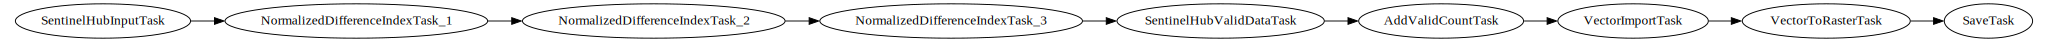

In [474]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

Це може зайняти деякий час, тож випийте чашку кави...

In [475]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )


  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: total: 17.4 s
Wall time: 11min 23s


## Візуалізуйте патчі
Давайте завантажимо один EOPatch і подивимось на структуру. Виконуючи

In [13]:
EOPatch.load('./eopatches/eopatch_0/')

EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(48, 500, 500, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(48, 500, 500, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(48, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(48, 500, 500, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(48, 500, 500, 1), dtype=bool)
  }
  mask_timeless={
    LULC: numpy.ndarray(shape=(500, 500, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(500, 500, 1), dtype=int64)
  }
  vector_timeless={
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['RABA_PID', 'RABA_ID', 'VIR', 'AREA', 'STATUS', 'D_OD', 'lulcid', 'lulcname', 'geometry'], length=1145, crs=EPSG:32633)
  }
  bbox=BBox(((500000.0, 5135000.0), (505000.0, 5140000.0)), crs=CRS('32633'))
  timestamps=[datetime.datetime(2019, 

Тоді можна отримати доступ до різного вмісту EOPatch за допомогою таких викликів:

```eopatch.timestamps
eopatch.mask['LULC']
eopatch.data['NDVI'][0]
eopatch.data['BANDS'][5][..., [3, 2, 1]]
```

Через фільтрацію maxcc не всі патчі мають однакову кількість позначок часу.

Давайте виберемо дату та намалюємо найближчу позначку часу для кожного eopatch.

  0%|          | 0/25 [00:00<?, ?it/s]

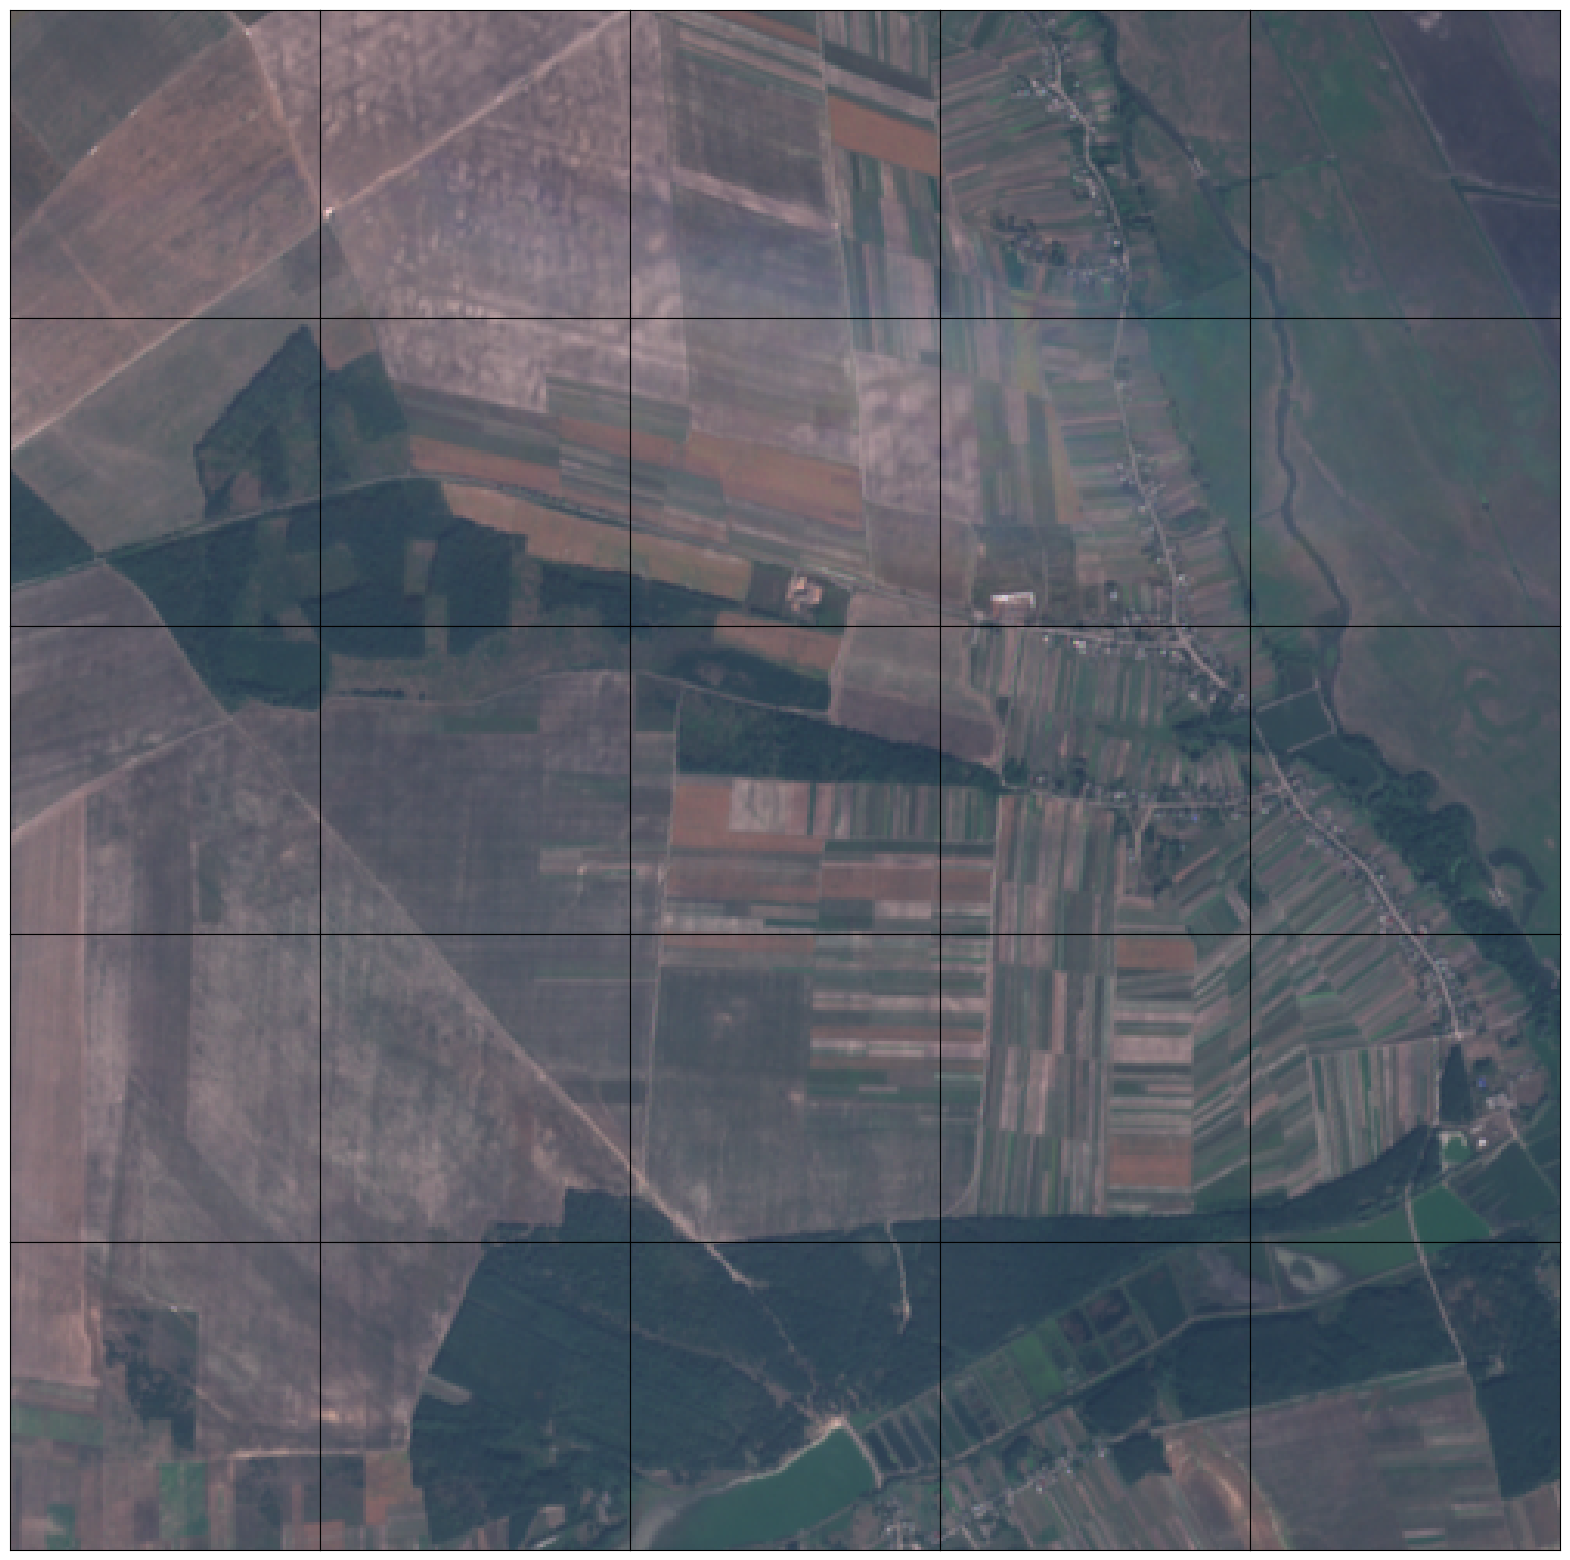

In [478]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019, 9, 10)

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamps])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

  0%|          | 0/25 [00:00<?, ?it/s]

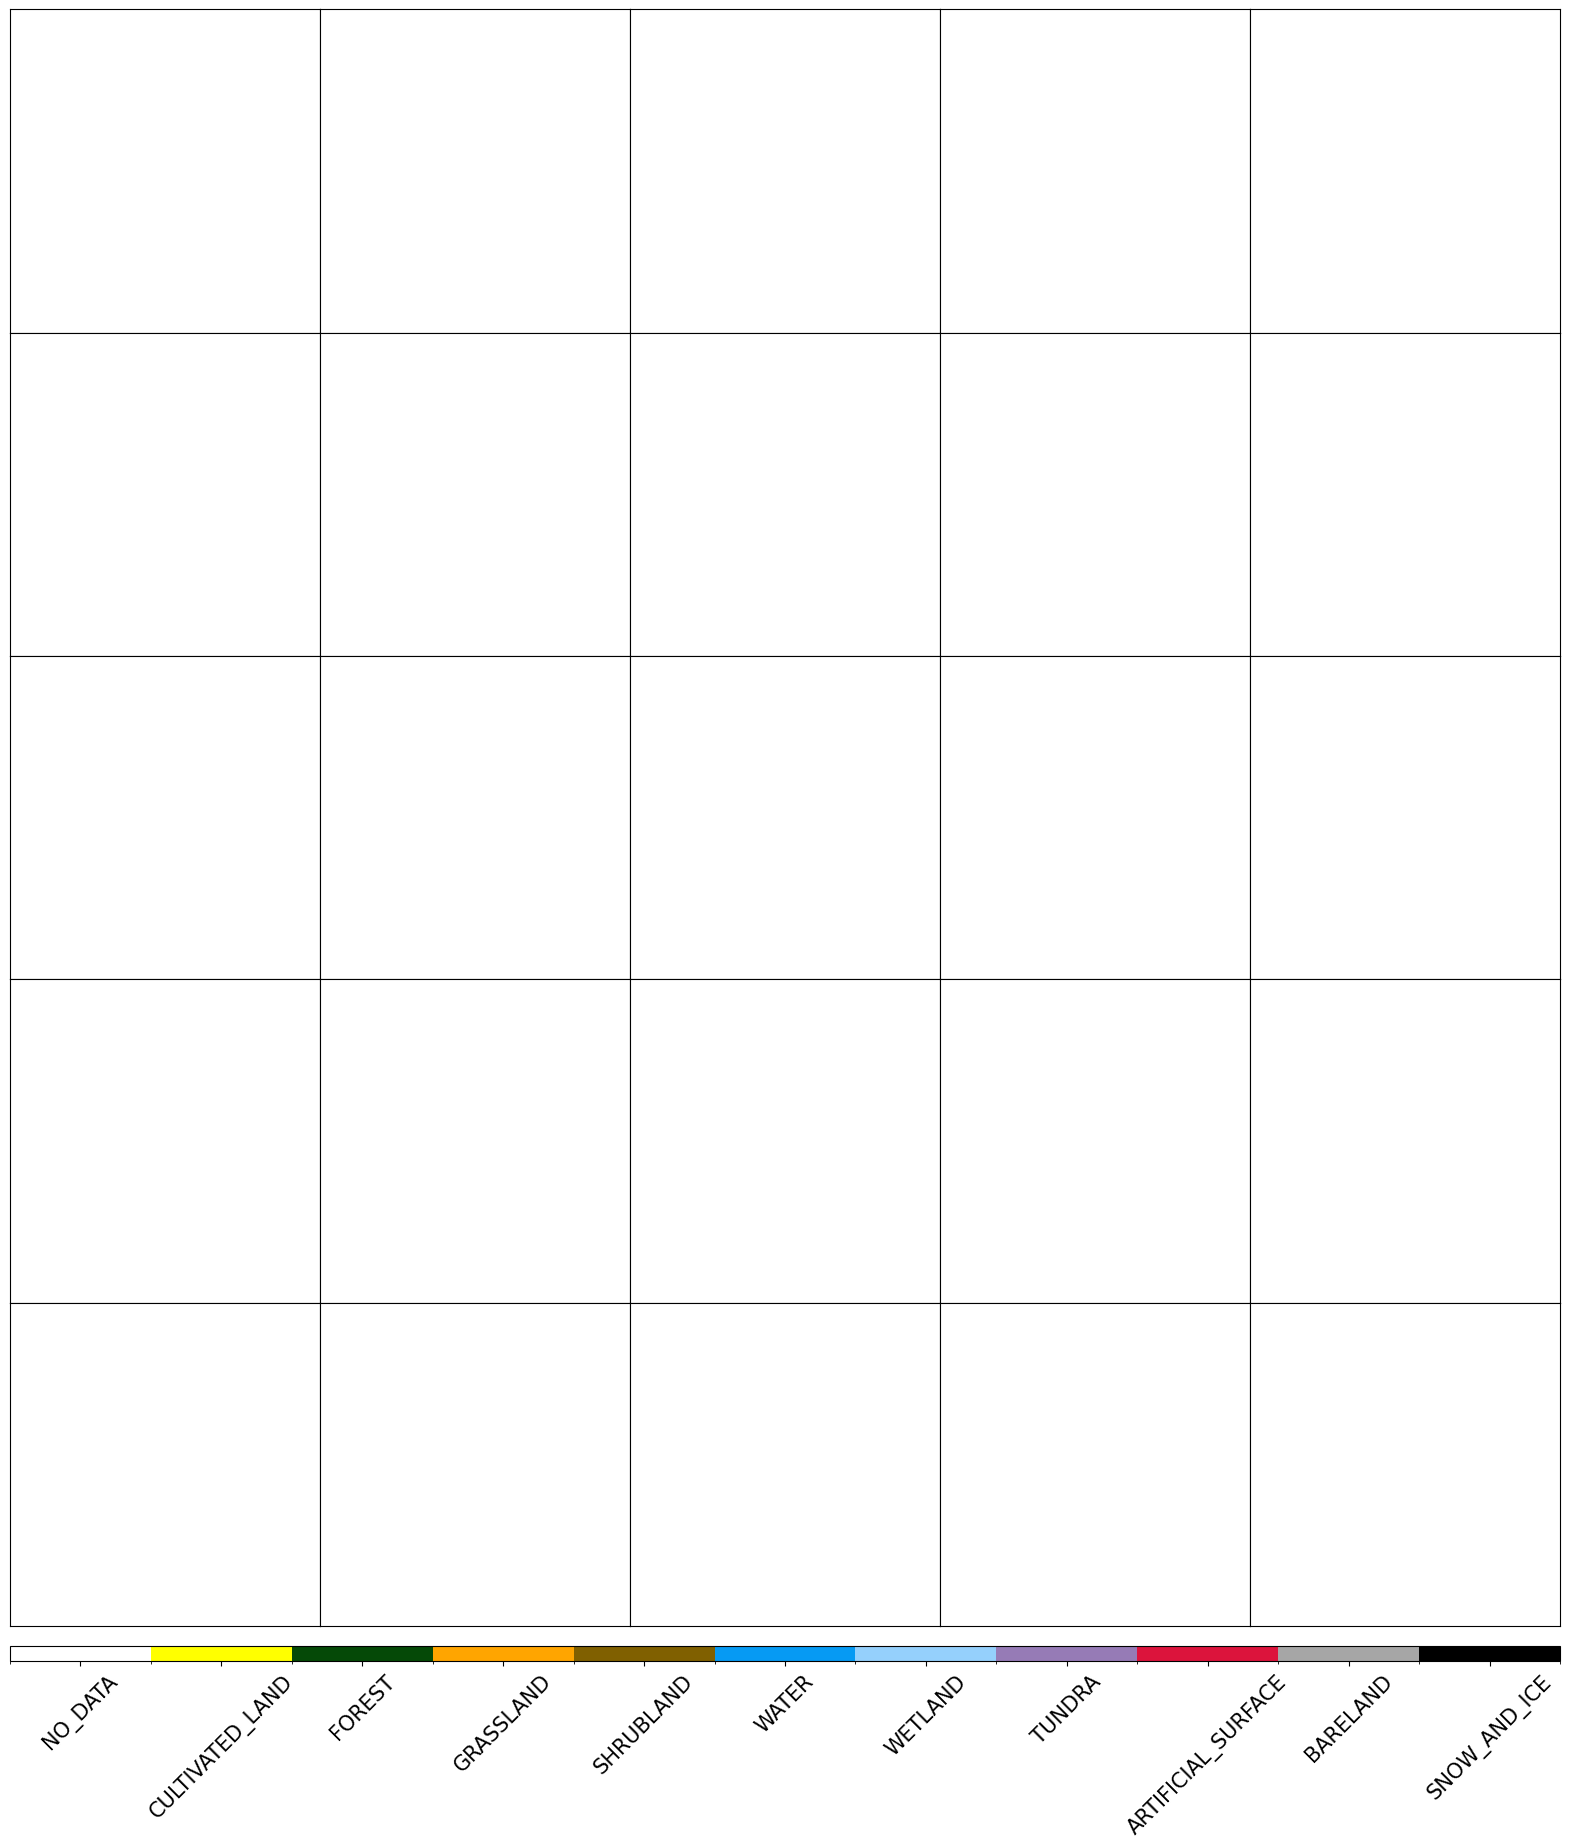

In [451]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))
# міняв range
for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LULC"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

## Частина 2
# 5. Підготуйте навчальні дані
Ми створимо новий робочий процес, який оброблятиме дані:

1. Видаліть надто мутні сцени
- Перевірте співвідношення дійсних даних для кожного патча та для кожного періоду часу
- Зберігайте лише часові рамки з > 80 % дійсного покриття (без хмар)
2. Об’єднайте інформацію про BAND, NDVI, NDWI, NDBI в одну функцію під назвою FEATURES
3. Виконайте часову інтерполяцію (заповнення пропусків і повторна вибірка до тих самих дат)
- Створіть завдання на лінійну інтерполяцію в часовому вимірі
- Надайте хмарну маску, щоб повідомити функції інтерполяції, які значення оновлювати
4. Виконати ерозію
- Це видаляє артефакти шириною 1 піксель, а також видаляє краї між багатокутниками різних класів
5. Випадкова просторова вибірка EOPatches
- Випадково візьміть підмножину пікселів із патча для використання в навчанні машинного навчання
6. Розділені патчі для навчання/перевірки
- Розділіть патчі на набір для навчання та перевірки

## Визначте EOTasks

In [479]:
class ValidDataFractionPredicate:
    """Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [480]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ["BANDS", "NDVI", "NDWI", "NDBI"]}, (FeatureType.DATA, "FEATURES"))

# FILTER OUT CLOUDY SCENES
# Keep frames with > 80% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, "IS_VALID"), valid_data_predicate)

# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ("2019-01-01", "2019-12-31", 15)
linear_interp = LinearInterpolationTask(
    (FeatureType.DATA, "FEATURES"),  # name of field to interpolate
    mask_feature=(FeatureType.MASK, "IS_VALID"),  # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, "LULC")],  # features to keep
    resample_range=resampled_range,
)

# EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LULC", "LULC_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "FEATURES", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LULC_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LULC_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [481]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(load, concatenate, filter_task, linear_interp, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

## Запустіть EOWorkflow над усіма EOPatches

In [482]:
%%time

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # load
            workflow_nodes[-2]: {"seed": 42},  # sampling
            workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"},  # save
        }
    )

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: total: 4.27 s
Wall time: 14.7 s


## 6. Побудова та навчання моделі
Патчі поділяються на підмножину тренування та тестування, де ми розділяємо патчі для навчання та тестування.

Тестовий зразок вибирається вручну через невеликий набір патчів, інакше з великим загальним набором патчі для навчання та тестування слід вибирати випадковим чином.

Вибрані функції та мітки завантажуються та змінюються в n*m, де n представляє кількість навчальних пікселів, і m=f*t кількість усіх ознак (в даному прикладі 216), з f розмір смуг і комбінацій смуг (у цьому прикладі 9) і t довжина зміненого часового ряду (у цьому прикладі 25)

LightGBM використовується як модель ML. Це швидка, розподілена, високопродуктивна система посилення градієнта на основі алгоритмів дерева рішень, яка використовується для багатьох завдань машинного навчання.

У цьому прикладі використовуються гіперпараметри за замовчуванням. Щоб дізнатися більше про налаштування параметрів, перегляньте ReadTheDocs пакета.

In [28]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patchIDs)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [29]:
# Definition of the train and test patch IDs, take 80 % for train
test_ids = [0, 8, 16, 19, 20]
test_eopatches = [sampled_eopatches[i] for i in test_ids]
train_ids = [i for i in range(len(patchIDs)) if i not in test_ids]
train_eopatches = [sampled_eopatches[i] for i in train_ids]

# Set the features and the labels for train and test sets
features_train = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in train_eopatches], axis=1)
labels_train = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in train_eopatches], axis=0)

features_test = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in test_eopatches], axis=1)
labels_test = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in test_eopatches], axis=0)

# Get shape
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape to n x m
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)
features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

In [30]:
features_train.shape

(1319244, 225)

## Налаштуйте та навчіть модель

In [298]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective="multiclass", num_class=len(labels_unique), metric="multi_logloss", random_state=42
)

# Train the model
model.fit(features_train, labels_train)

# Save the model
joblib.dump(model, os.path.join(RESULTS_FOLDER, "model_SI_LULC.pkl"))

CPU times: total: 23min 17s
Wall time: 3min 35s


['.\\results\\model_SI_LULC.pkl']

## 7. Валідація
Перевірка моделі є вирішальним кроком у науці про дані. Усі моделі помилкові, але деякі менш помилкові, ніж інші, тому оцінка моделі важлива.

Щоб перевірити модель, ми використовуємо навчальний набір для прогнозування класів, а потім порівнюємо прогнозований набір міток із «основною правдою».

На жаль, базова істина в рамках EO — це термін, до якого слід ставитися легковажно. Зазвичай це не є 100% надійним через кілька причин:

- Мітки визначаються в певний час, але землекористування може змінюватися (те, що колись було полем, тепер може бути будинком)
- Мітки надто узагальнені (місто – це штучна поверхня, але в ньому також є парки, ліси тощо)
Деякі класи можуть мати перекриття або схожі визначення (частина континууму, а не дискретний розподіл)
- Людська помилка (помилки, допущені під час створення еталонної карти)
Перевірка виконується шляхом оцінки різних показників, таких як точність, точність, запам’ятовування, F1 оцінка, деякі з яких гарно описані в цій публікації блогу.

In [483]:
# Load the model
model_path = "D:/Lessons/Diplom/Zaloga_diplom/results/model_SI_LULC_main.pkl"
model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

Отримайте загальну точність (OA) і зважену оцінку F1, а також оцінку F1, точність і запам’ятовування для кожного класу окремо

In [322]:
class_labels = np.unique(labels_test)
class_names = [lulc_type.name for lulc_type in LULC]
mask = np.in1d(predicted_labels_test, labels_test)
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(*line_data))

Classification accuracy 89.8%
Classification F1-score 89.6%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * CULTIVATED_LAND      = 85.5 |  83.1  | 88.2
         * FOREST               = 97.7 |  97.7  | 97.7
         * GRASSLAND            = 84.7 |  89.5  | 80.4
         * SHRUBLAND            = 29.2 |  22.7  | 41.1
         * WATER                = 66.9 |  92.9  | 52.3
         * WETLAND              = 0.7 |  11.1  | 0.3
         * ARTIFICIAL_SURFACE   = 74.1 |  69.8  | 78.8


## Побудуйте стандартну та транспоновану матрицю плутанини

In [302]:
def plot_confusion_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

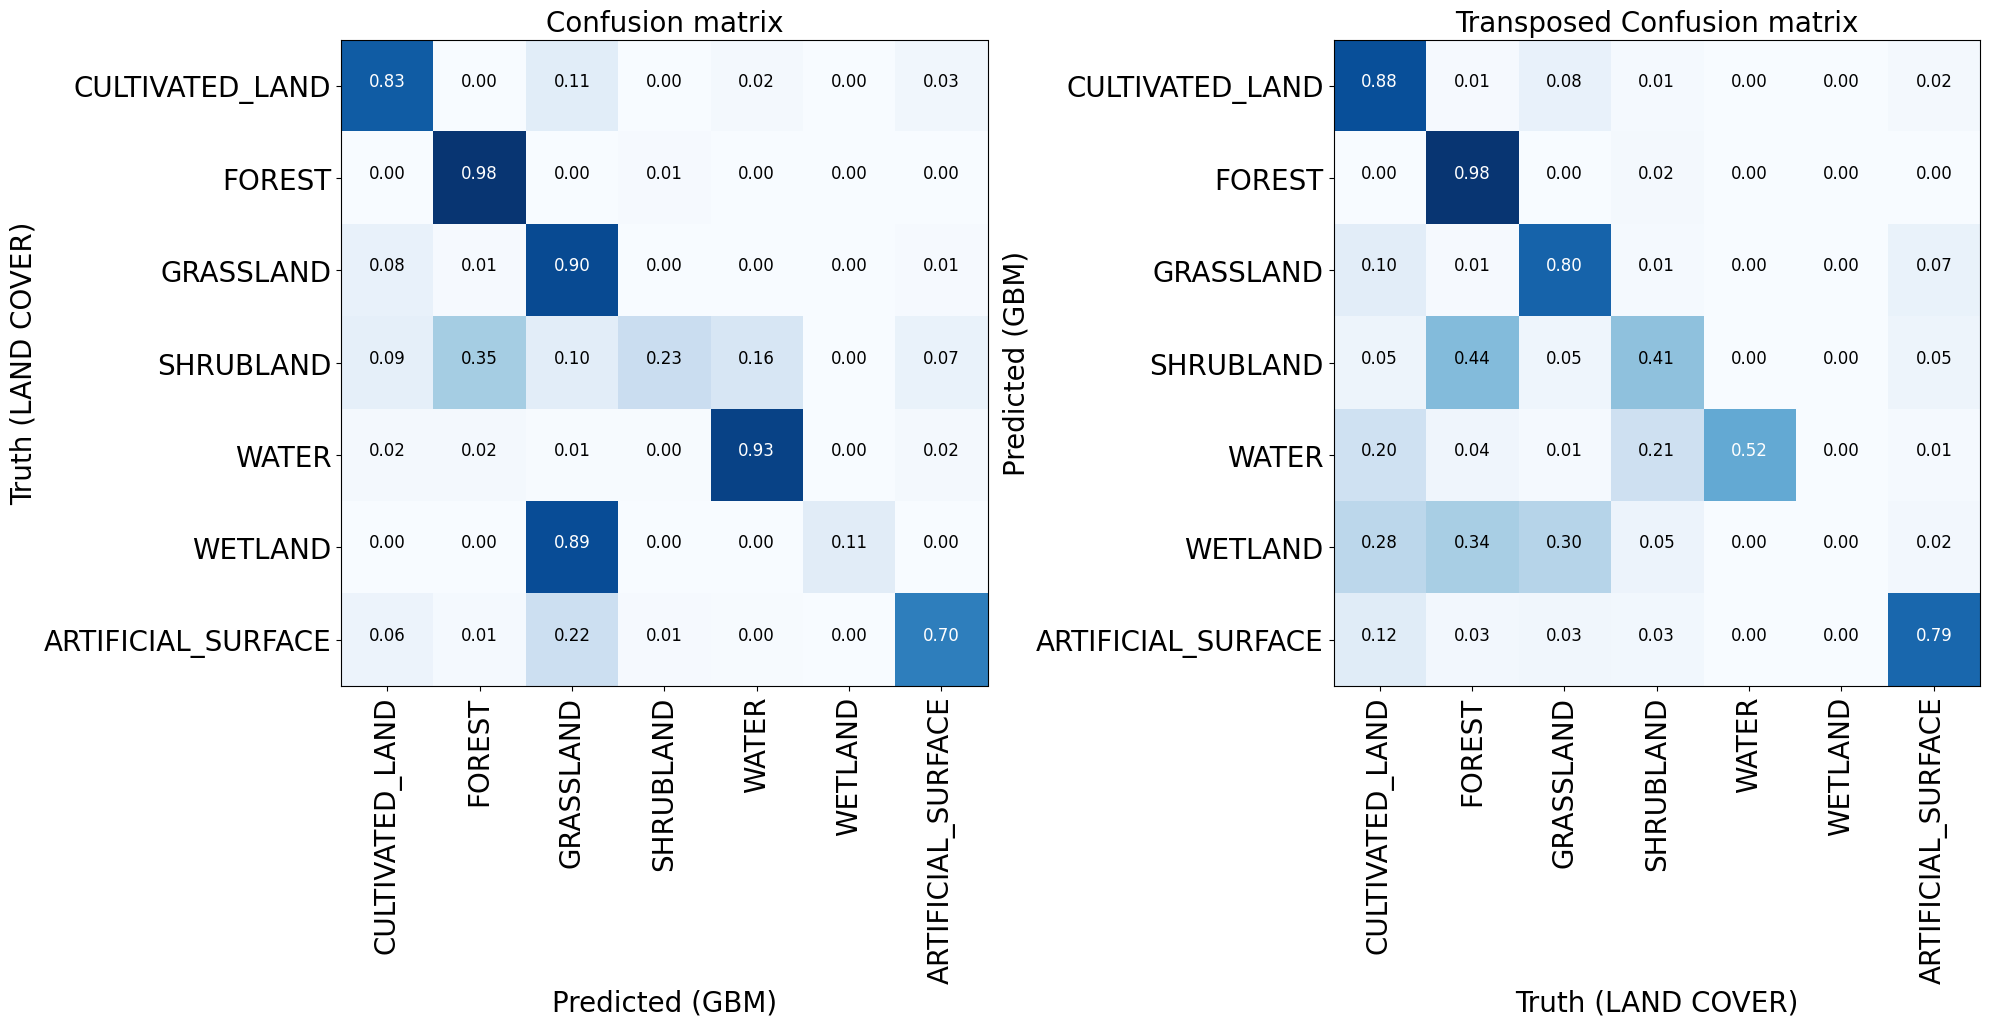

In [303]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = metrics.confusion_matrix(true_labels, predictions)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    ylabel="Truth (LAND COVER)",
    xlabel="Predicted (GBM)",
    title="Confusion matrix",
)

plt.subplot(1, 2, 2)
confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    xlabel="Truth (LAND COVER)",
    ylabel="Predicted (GBM)",
    title="Transposed Confusion matrix",
)

plt.tight_layout()

Для більшості класів модель виглядає добре. Інакше навчальна вибірка, ймовірно, буде занадто малою, щоб зробити справедливу оцінку. Додаткові проблеми виникають через незбалансований комплекс тренувань. На зображенні нижче показано частоту класів, які використовуються для навчання моделям, і ми бачимо, що проблемними випадками є всі недостатньо представлені класи: чагарники, водойми, водно-болотні угіддя та голі землі.

Покращення еталонної карти також вплине на кінцевий результат, оскільки, наприклад, деякі класи змішуються до певного рівня.

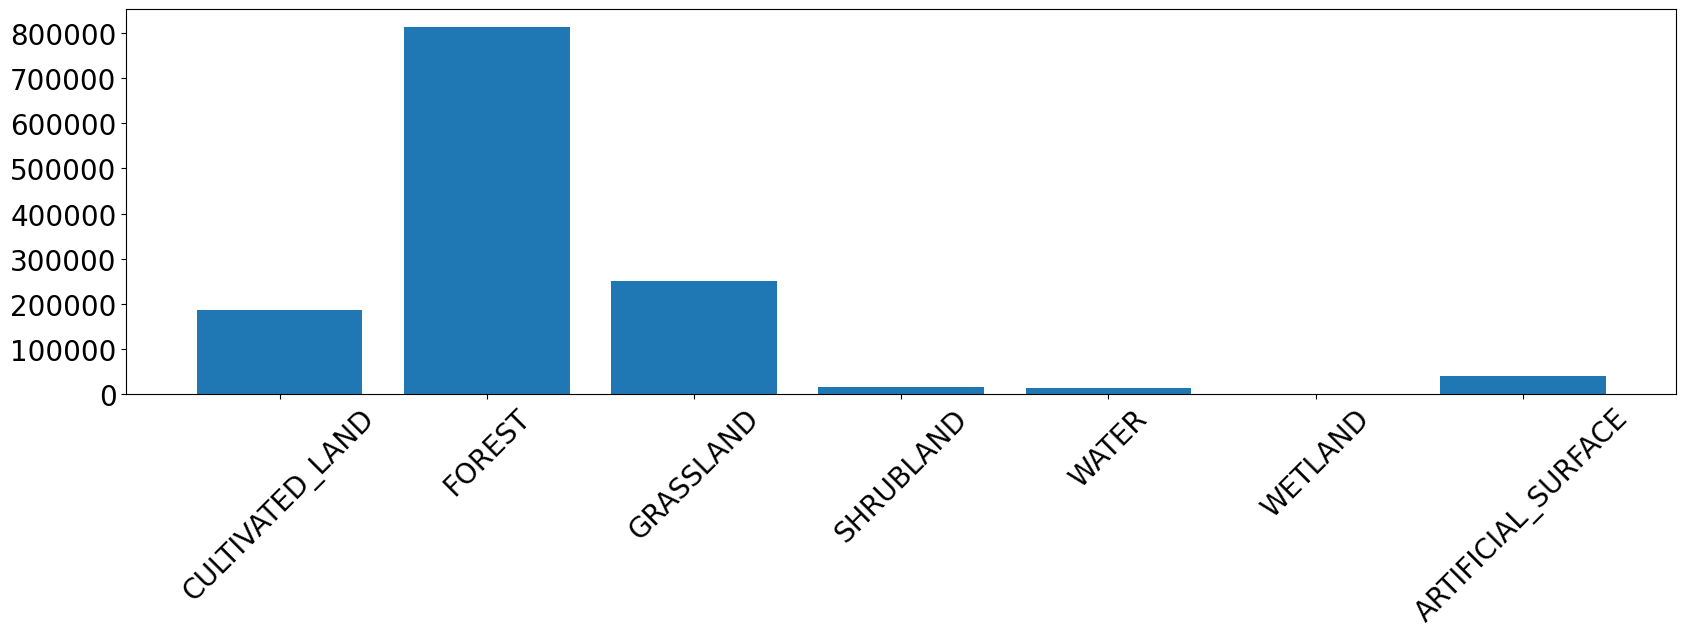

In [304]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20)
plt.yticks(fontsize=20);

  0%|          | 0/25 [00:00<?, ?it/s]

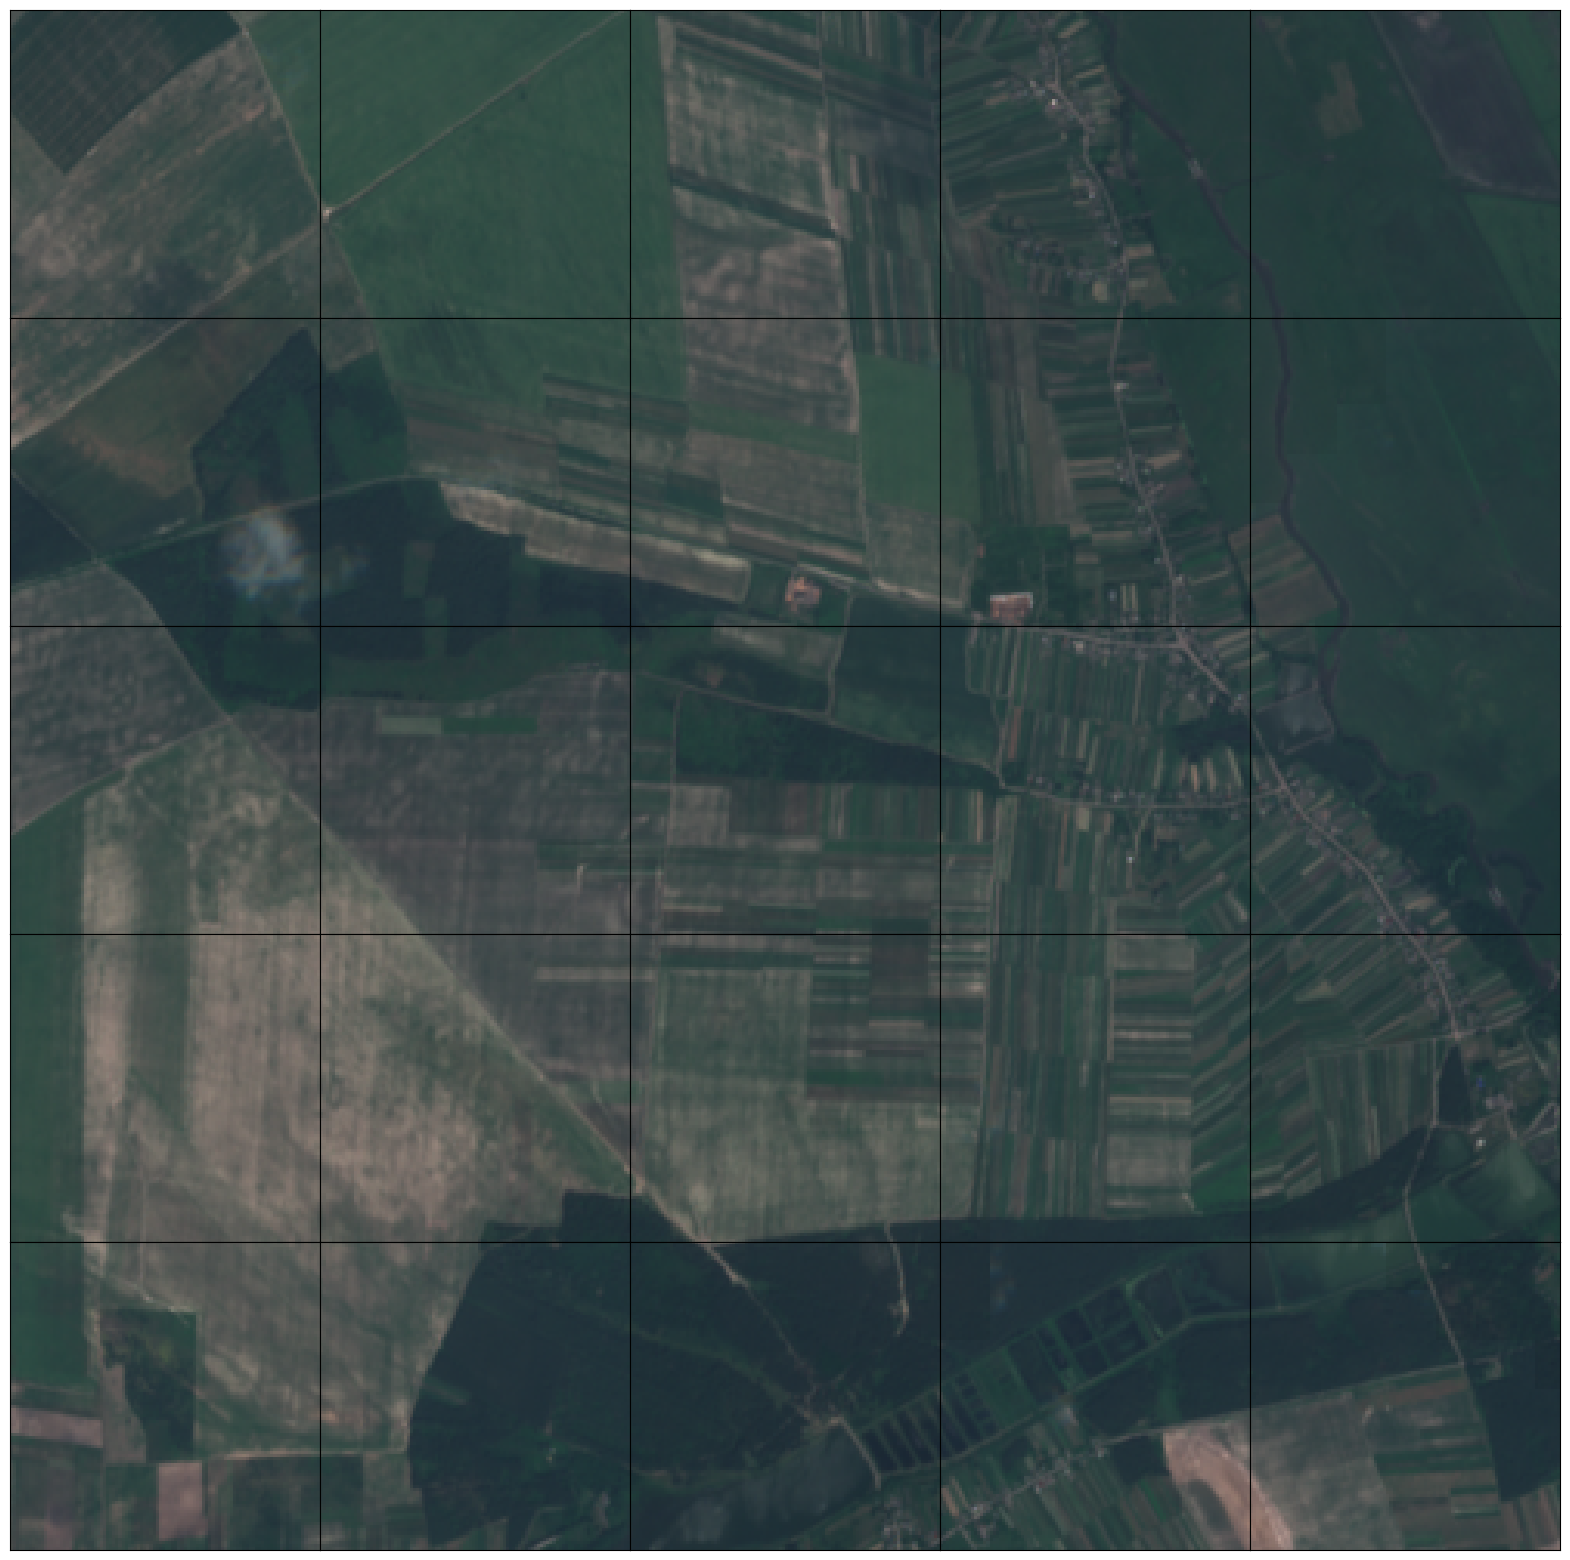

In [485]:
# Feature names
fnames = ["B2", "B3", "B4", "B8", "B11", "B12", "NDVI", "NDWI", "NDBI"]

# Get feature importances and reshape them to dates and features
feature_importances = model.feature_importances_.reshape((t, f))

# Draw the RGB image
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

time_id = np.where(feature_importances == np.max(feature_importances))[0][0]

for i in tqdm(range(len(patchIDs))):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(sample_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["FEATURES"][time_id][..., [2, 1, 0]] * 2.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

## 8. Візуалізація результатів
Модель перевірено, залишилося зробити прогноз на весь AOI.

Тут ми визначаємо робочий процес, щоб зробити прогноз моделі на існуючих EOPatces. EOTask приймає функції та назви для міток і балів. Останнє є необов’язковим.

Визначте EOTasks

In [486]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """

    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        features = eopatch[self.features_feature]

        t, w, h, f = features.shape
        features = np.moveaxis(features, 0, 2).reshape(w * h, t * f)

        predicted_labels = self.model.predict(features)
        predicted_labels = predicted_labels.reshape(w, h)
        predicted_labels = predicted_labels[..., np.newaxis]
        eopatch[(FeatureType.MASK_TIMELESS, self.predicted_labels_name)] = predicted_labels

        if self.predicted_scores_name:
            predicted_scores = self.model.predict_proba(features)
            _, d = predicted_scores.shape
            predicted_scores = predicted_scores.reshape(w, h, d)
            eopatch[(FeatureType.DATA_TIMELESS, self.predicted_scores_name)] = predicted_scores

        return eopatch

## Визначте завдання та робочий процес
тут лоад підмінити

In [487]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_SAMPLES_FOLDER)

# PREDICT
predict = PredictPatchTask(model, (FeatureType.DATA, "FEATURES"), "LBL_GBM", "SCR_GBM")

# SAVE
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# EXPORT TIFF
tiff_location = os.path.join(RESULTS_FOLDER, "predicted_tiff")
os.makedirs(tiff_location, exist_ok=True)
export_tiff = ExportToTiffTask((FeatureType.MASK_TIMELESS, "LBL_GBM"), tiff_location)

workflow_nodes = linearly_connect_tasks(load, predict, export_tiff, save)
workflow = EOWorkflow(workflow_nodes)
print(tiff_location)

.\results\predicted_tiff


Запустіть прогноз і експортуйте зображення в GeoTIFF
Тут ми використовуємо EOExecutor для паралельного запуску робочого процесу.

In [488]:
# Create a list of execution arguments for each patch
tiff_location=""
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{i}"},
            workflow_nodes[2]: {"filename": f"{tiff_location}/prediction_eopatch_{i}.tiff"},
            workflow_nodes[3]: {"eopatch_folder": f"eopatch_{i}"},
        }
    )

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/25 [00:00<?, ?it/s]

Візуалізуйте передбачення

  0%|          | 0/25 [00:00<?, ?it/s]

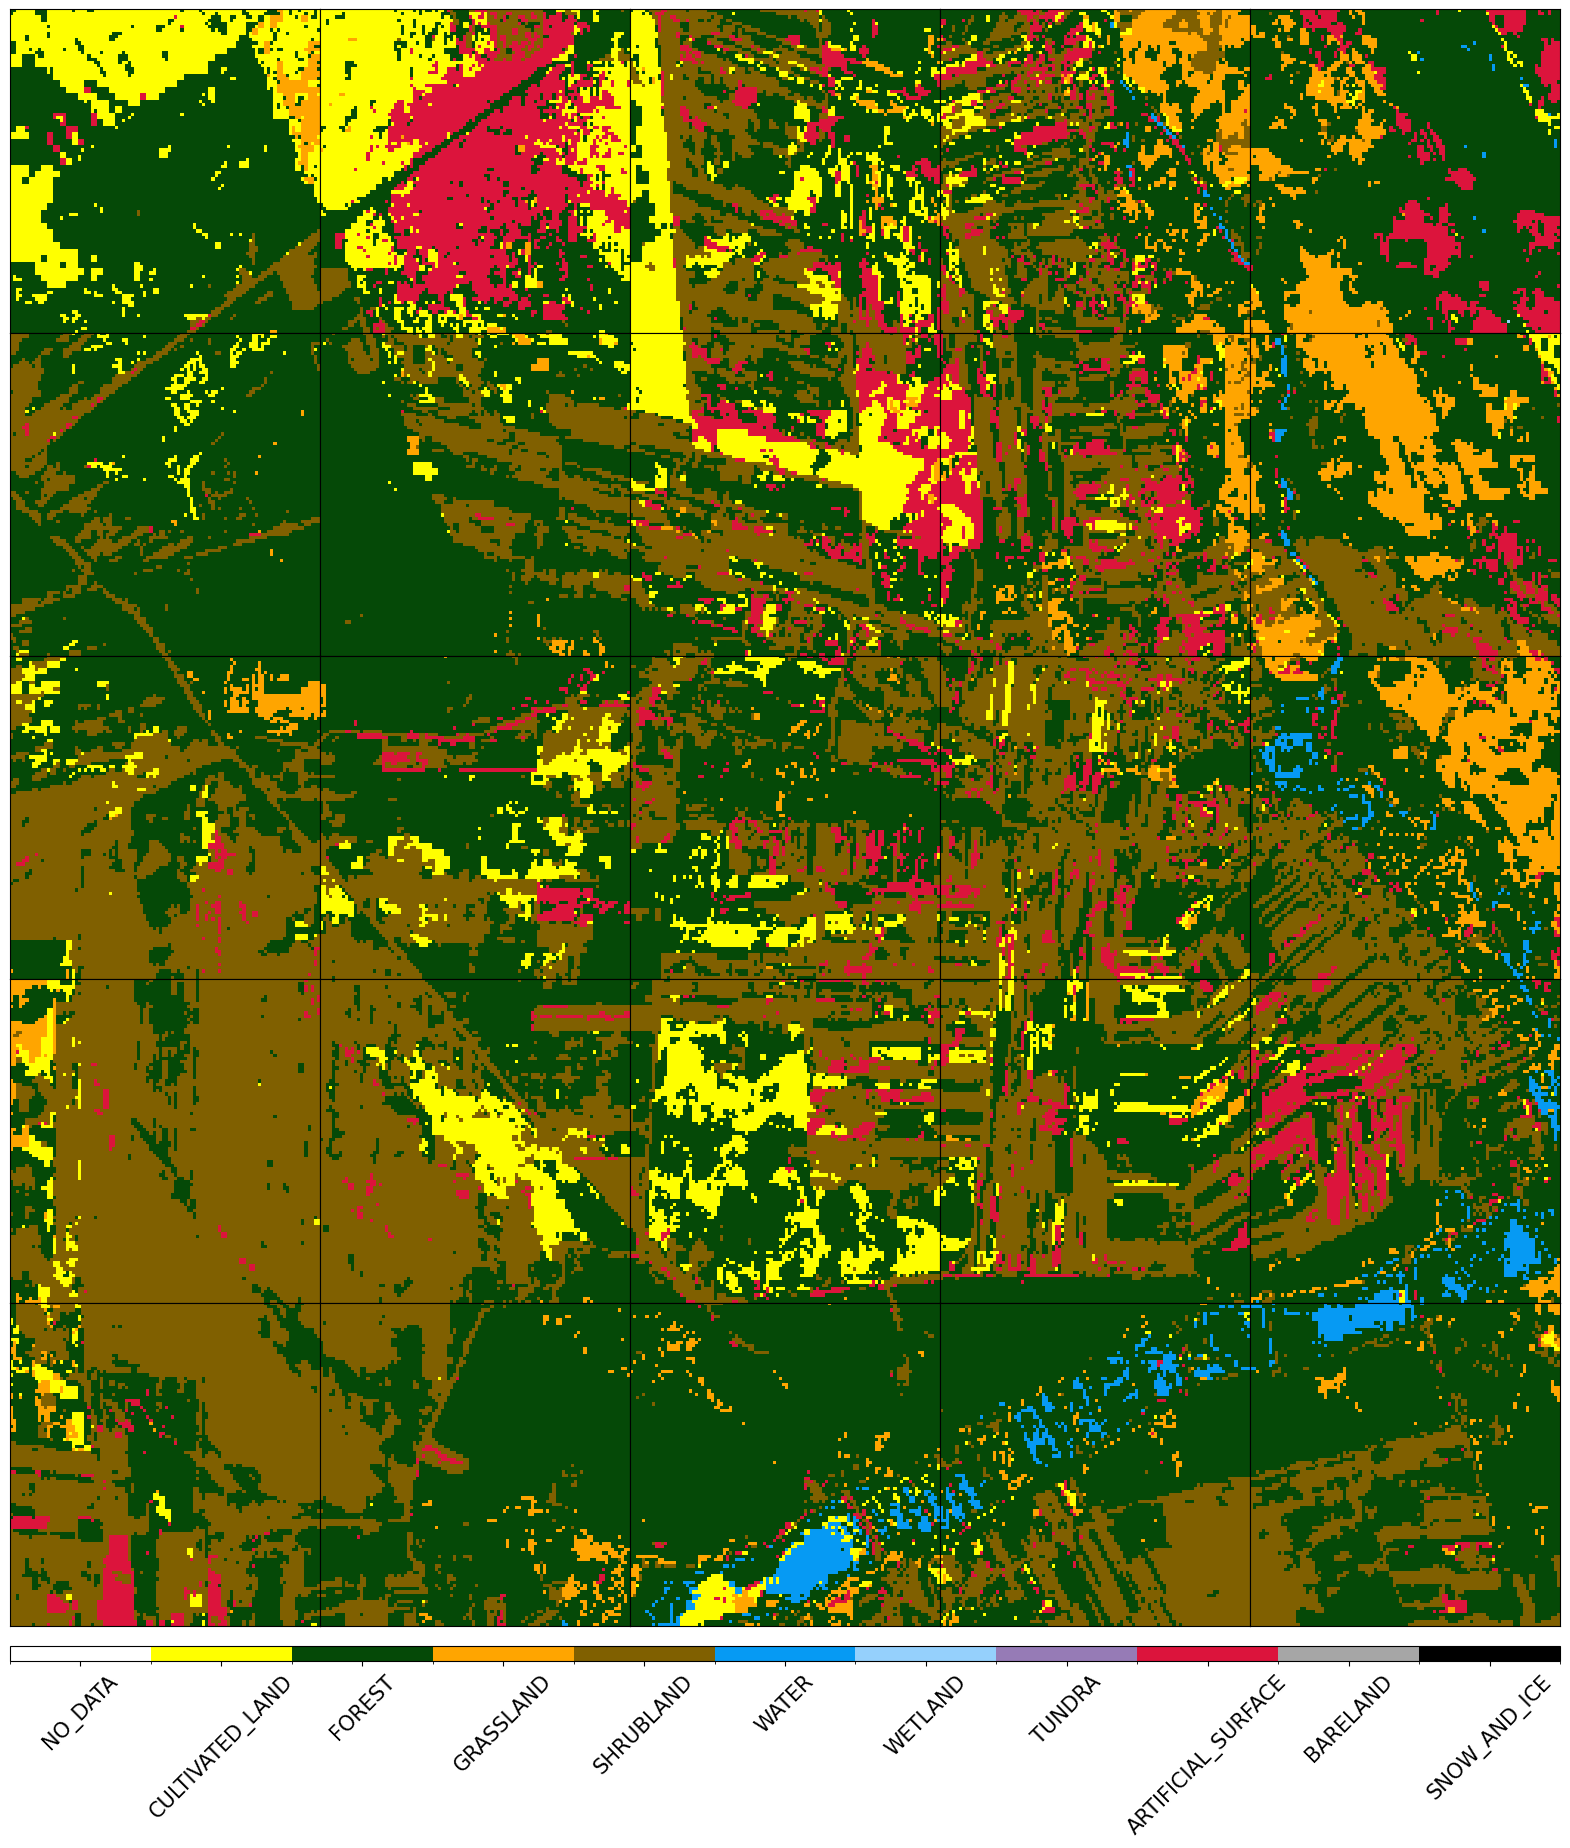

In [490]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()


Візуальний огляд латок
Ось лише простий фрагмент коду, який дозволяє ближче перевірити прогнозовані мітки.

Вибираються випадкові підмножини патчів, де порівнюються прогноз і базова правда. Для наочної допомоги також надано маску відмінностей і реальне кольорове зображення.

У більшості випадків відмінності, здається, лежать на межі різних структур.

100
18


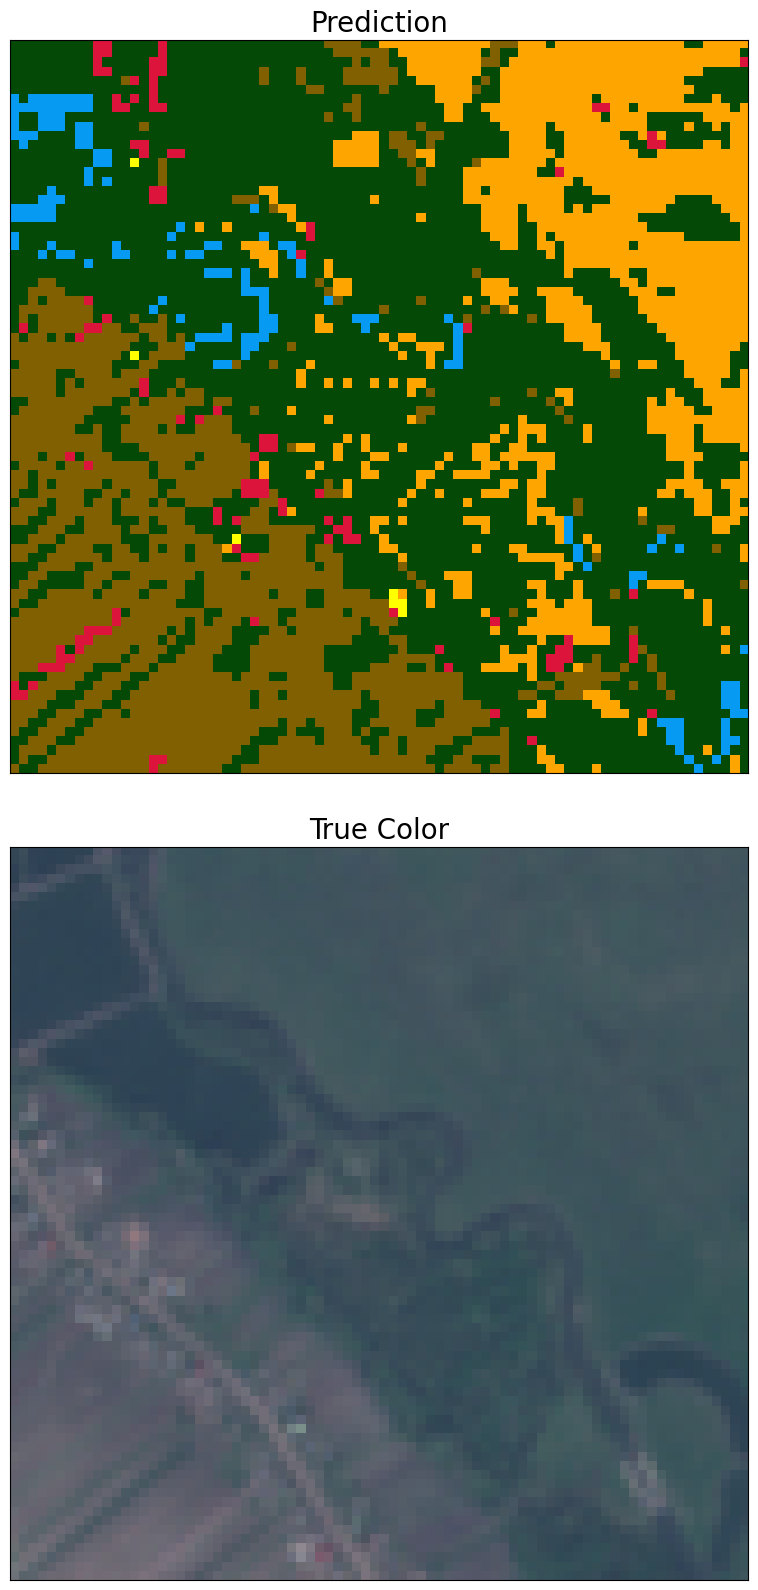

In [500]:
# Draw the Reference map
fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(len(patchIDs)))
inspect_size = 80

eopatch = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{idx}"), lazy_loading=True)

w, h = eopatch.mask_timeless["LULC"].squeeze().shape
print(w)
w_min = np.random.choice(range(w - inspect_size))
print(w_min)
w_max = w_min + inspect_size
h_min = np.random.choice(range(h - inspect_size))
h_max = h_min + inspect_size
'''
ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless["LULC"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Ground Truth", fontsize=20)
'''
ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Prediction", fontsize=20)
'''
ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless["LBL_GBM"].squeeze() != eopatch.mask_timeless["LULC"].squeeze()
plt.imshow(mask[w_min:w_max, h_min:h_max], cmap="gray")
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Difference", fontsize=20)
'''
ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data["FEATURES"][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min:w_max, h_min:h_max])
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("True Color", fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)